In [1]:
pip install umap-learn

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 1.2MB 9.0MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=dbdaeb8bbce4e4c076bd75ff220ea0a68bbd5cd526d91e210f502577531b5278
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=177f06cc883ae124369b02ca270872dc06b51a0cdd592bab3685c223c1456cd0
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [2]:
#Load Library
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP

In [3]:
bansos_data = pd.read_csv("/content/drive/MyDrive/dataset_bansos.csv")

In [4]:
Features = bansos_data.drop(["id","umur","nik","ibu_hamil","lanjut_usia","disabilitas","bpnt","bst","pkh"], axis = 1).columns
display(Features)

Index(['gaji', 'j_tanggungjawab', 'j_motor', 'j_mobil'], dtype='object')

In [5]:
X = bansos_data[Features]

In [6]:
X.sample(5, random_state=0)

,gaji,j_tanggungjawab,j_motor,j_mobil
597,1000000,9,6,2
822,2500000,2,6,0
97,3500000,4,0,0
75,1000000,9,0,0
249,1500000,1,2,0


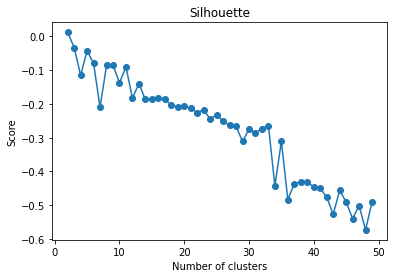

In [7]:
sc = []
for i in range(2, 50):
    kmeans = Pipeline([("scaling",StandardScaler()),("umap",UMAP()),("clustering",KMeans(n_clusters=i, init='k-means++',random_state=0))]).fit(X)
    score = silhouette_score(X, kmeans["clustering"].labels_)
    sc.append(score)
plt.plot(range(2, 50), sc, marker = "o")
plt.title('Silhouette')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

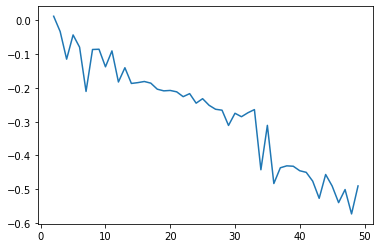

In [8]:
plt.plot(range(2,50), sc)
plt.savefig('Elbow Method.png')
plt.show()

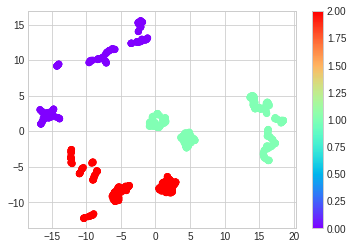

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
kmeans = Pipeline([("scaling",StandardScaler()),("umap",UMAP()),("clustering",KMeans(n_clusters=3, init='k-means++',random_state=0))]).fit(X)
pca = Pipeline([("scaling",StandardScaler()),("umap",UMAP()),("decompositioning",PCA(n_components = 2))]).fit(X)
X2D = pca.transform(X)
plt.scatter(X2D[:,0],X2D[:,1], c = kmeans["clustering"].labels_, cmap = "rainbow")
plt.colorbar();
plt.savefig('Kluster3.png')

In [10]:
y_cluster = kmeans.fit_predict(X2D)

In [11]:
from sklearn.tree import _tree, DecisionTreeClassifier

In [12]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=20, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [13]:
from IPython.display import display, HTML
cluster_report(X, y_cluster, min_samples_leaf=20, pruning_level=0.01)

,class_name,instance_count,rule_list
0,0,373,[1.0] (j_mobil <= 1.5) and (j_mobil <= 0.5) and (gaji <= 2000000.0)[0.9506172839506173] (j_mobil <= 1.5) and (j_mobil <= 0.5) and (gaji > 2000000.0) and (j_tanggungjawab > 3.5)[1.0] (j_mobil > 1.5) and (j_motor <= 1.5) and (gaji <= 2000000.0) and (j_motor > 0.5)
2,1,325,[0.7368421052631579] (j_mobil > 1.5) and (j_motor <= 1.5) and (gaji <= 2000000.0) and (j_motor <= 0.5)[1.0] (j_mobil > 1.5) and (j_motor <= 1.5) and (gaji > 2000000.0)[1.0] (j_mobil > 1.5) and (j_motor > 1.5)
1,2,340,[0.6571428571428571] (j_mobil <= 1.5) and (j_mobil <= 0.5) and (gaji > 2000000.0) and (j_tanggungjawab <= 3.5)[0.9690402476780186] (j_mobil <= 1.5) and (j_mobil > 0.5)


In [ ]:
#Test Model With any data
